<a href="https://colab.research.google.com/github/tanyach08/human-burn-classification/blob/main/skinburnclassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install roboflow

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="3VTqHbHMikPHRoA3WTmB")
project = rf.workspace("aibuildersclub").project("skin-burns-4yoo2")
version = project.version(3)
dataset = version.download("yolov5")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Skin-Burns--3 in yolov5pytorch:: 100%|██████████| 9538/9538 [00:03<00:00, 2630.34it/s]


In [ ]:
import os
import shutil

In [ ]:
image_folder = '/content/Skin-Burns--3/test/images'
annotation_folder = '/content/Skin-Burns--3/test/labels'
output_folder = '/content/Skin-Burns--3/test1'

os.makedirs(output_folder, exist_ok=True)

for filename in os.listdir(annotation_folder):
    if filename.endswith('.txt'):
        with open(os.path.join(annotation_folder, filename), 'r') as file:
            line = file.readline().strip()
            class_label, xmin, ymin, xmax, ymax = map(float, line.split())

            class_folder = os.path.join(output_folder, str(int(class_label)))
            os.makedirs(class_folder, exist_ok=True)

            image_name = os.path.splitext(filename)[0] + '.jpg'
            shutil.copyfile(os.path.join(image_folder, image_name),
                            os.path.join(class_folder, image_name))

In [ ]:
import os
import shutil

image_folder = '/content/Skin-Burns--3/train/images'
annotation_folder = '/content/Skin-Burns--3/train/labels'
output_folder = '/content/Skin-Burns--3/train1'

os.makedirs(output_folder, exist_ok=True)

for filename in os.listdir(annotation_folder):
    if filename.endswith('.txt'):
        with open(os.path.join(annotation_folder, filename), 'r') as file:
            line = file.readline().strip()
            class_label, xmin, ymin, xmax, ymax = map(float, line.split())

            class_folder = os.path.join(output_folder, str(int(class_label)))
            os.makedirs(class_folder, exist_ok=True)

            image_name = os.path.splitext(filename)[0] + '.jpg'
            shutil.copyfile(os.path.join(image_folder, image_name),
                            os.path.join(class_folder, image_name))

In [ ]:
import os
import shutil

image_folder = '/content/Skin-Burns--3/valid/images'
annotation_folder = '/content/Skin-Burns--3/valid/labels'
output_folder = '/content/Skin-Burns--3/valid1'

os.makedirs(output_folder, exist_ok=True)

for filename in os.listdir(annotation_folder):
    if filename.endswith('.txt'):
        with open(os.path.join(annotation_folder, filename), 'r') as file:
            line = file.readline().strip()
            class_label, xmin, ymin, xmax, ymax = map(float, line.split())

            class_folder = os.path.join(output_folder, str(int(class_label)))
            os.makedirs(class_folder, exist_ok=True)

            image_name = os.path.splitext(filename)[0] + '.jpg'
            shutil.copyfile(os.path.join(image_folder, image_name),
                            os.path.join(class_folder, image_name))

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#resizing images
import os
from PIL import Image

dataset_folder = '/content/Skin-Burns--3'
output_folder = '/content/Skin-Burns--3'
target_size = (224, 224)

os.makedirs(output_folder, exist_ok=True)

def resize_image(image_path, output_path, target_size):
    with Image.open(image_path) as img:
        resized_img = img.resize(target_size)
        resized_img.save(output_path)
for folder in ['train1', 'test1', 'valid1']:
    folder_path = os.path.join(dataset_folder, folder)
    if os.path.isdir(folder_path):
        output_folder_path = os.path.join(output_folder, folder)
        os.makedirs(output_folder_path, exist_ok=True)

        for class_folder in os.listdir(folder_path):
            class_path = os.path.join(folder_path, class_folder)
            if os.path.isdir(class_path):
                output_class_folder = os.path.join(output_folder_path, class_folder)
                os.makedirs(output_class_folder, exist_ok=True)
                for image_name in os.listdir(class_path):
                    image_path = os.path.join(class_path, image_name)
                    output_image_path = os.path.join(output_class_folder, image_name)
                    resize_image(image_path, output_image_path, target_size)

In [ ]:
#data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_dir = '/content/Skin-Burns--3/train1'
valid_dir = '/content/Skin-Burns--3/valid1'
test_dir = '/content/Skin-Burns--3/test1'

img_size = (224, 224)
batch_size = 32

# Create ImageDataGenerator with augmentation for the training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.75, 1.25],
    channel_shift_range=0.25,
    fill_mode='nearest'
)

# Create ImageDataGenerator without augmentation for the validation and test sets
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)



Found 4164 images belonging to 3 classes.
Found 399 images belonging to 3 classes.
Found 200 images belonging to 3 classes.


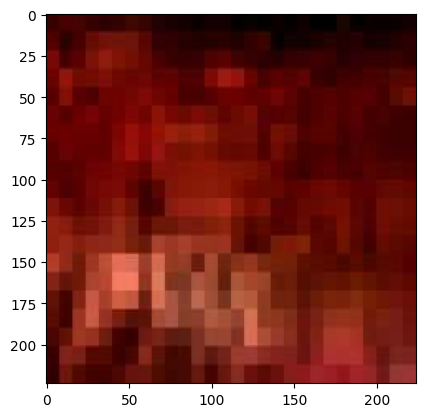

In [ ]:
from keras.preprocessing import image
import numpy as np

def crop_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    center_x, center_y = img_array.shape[1] // 2, img_array.shape[0] // 2
    crop_size = min(center_x, center_y)
    cropped_img_array = img_array[center_y - crop_size:center_y + crop_size, center_x - crop_size:center_x + crop_size, :]
    return image.array_to_img(cropped_img_array)

# Example
img_path = '/content/Skin-Burns--3/train1/1/img101_jpg.rf.1a4e471bc8567e3bdeaab5bef3adc798.jpg'
cropped_img = crop_image(img_path)
plt.imshow(cropped_img)
plt.show()


In [ ]:
#Simple ANN model

In [ ]:
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Flatten, Dense, BatchNormalization, Dropout
from keras.optimizers import Adam
model = Sequential()

model.add(Flatten(input_shape=(img_size[0], img_size[1], 3)))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(3, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

# Train the model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=valid_generator
)



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 150528)            0         
                                                                 
 dense_3 (Dense)             (None, 128)               19267712  
                                                                 
 batch_normalization_2 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_3 (Bat  (None, 64)                256       
 chNormalization)                                     

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy*100:.2f}%')

7/7 [==============================] - 0s 40ms/step - loss: 0.8742 - accuracy: 0.6000
Test Accuracy: 60.00%


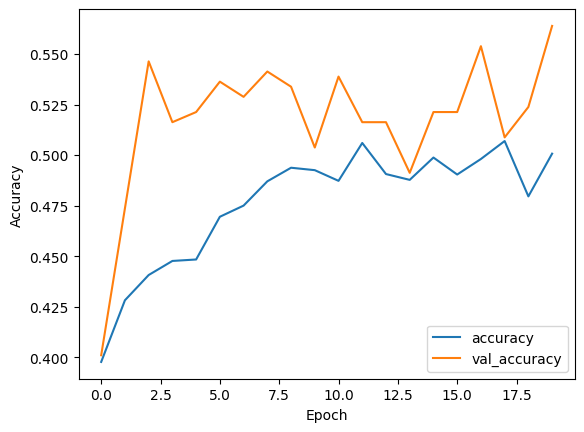

In [ ]:
#plotting
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
preds = model.predict(test_generator)
y_pred = np.argmax(preds, axis=1)

7/7 [==============================] - 0s 53ms/step


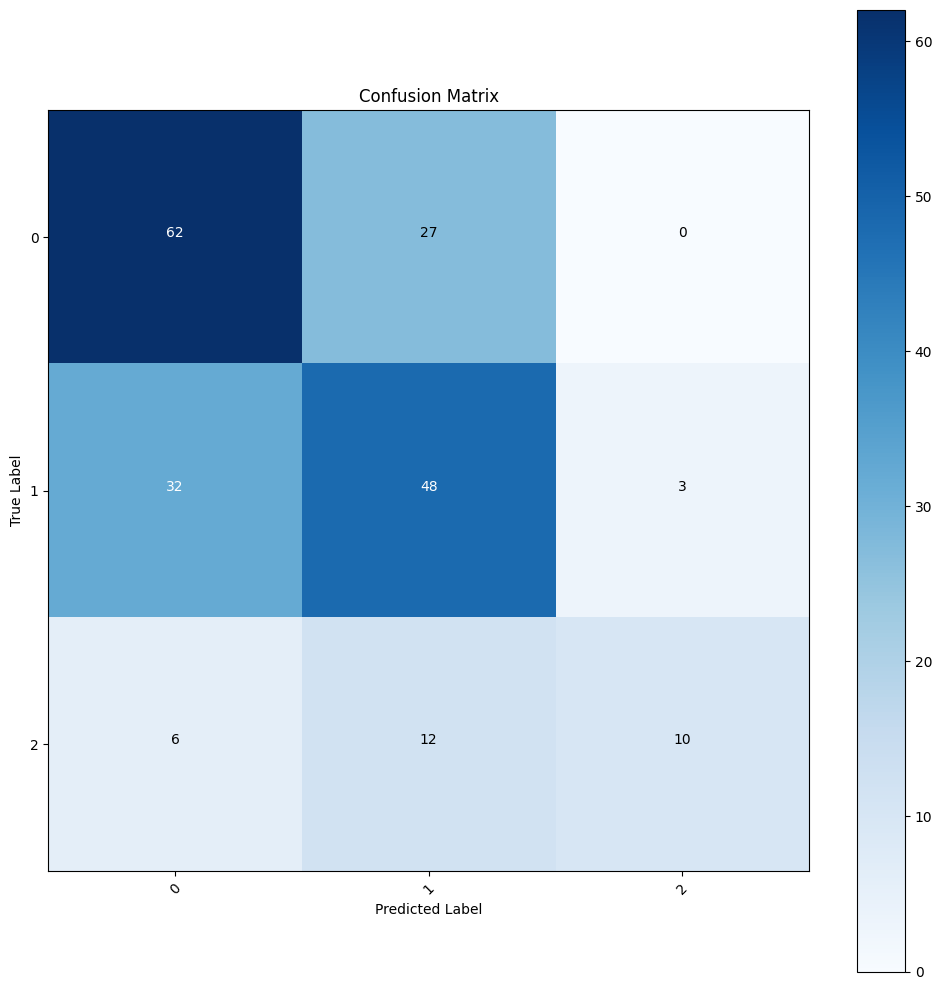

In [ ]:
g_dict = test_generator.class_indices
classes = list(g_dict.keys())
from sklearn.metrics import confusion_matrix
import itertools

# Confusion matrix
cm = confusion_matrix(test_generator.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
#Simple CNN Model

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam

# Create a simple CNN model
cnn_model = Sequential()
input_shape=(img_size[0], img_size[1], 3)

# Convolutional layers
cnn_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten layer
cnn_model.add(Flatten())

# Dense layers
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dense(64, activation='relu'))

# Output layer with softmax activation for multi-class classification
cnn_model.add(Dense(3, activation='softmax'))

# Compile the model
cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
cnn_model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 186624)            0         
                                                                 
 dense_6 (Dense)             (None, 128)              

In [ ]:


# Fitting the model
history = cnn_model.fit(
    train_generator,
    epochs=20,
    validation_data=valid_generator
)


Epoch 1/20
131/131 [==============================] - 63s 447ms/step - loss: 1.1699 - accuracy: 0.4726 - val_loss: 0.8747 - val_accuracy: 0.5639
Epoch 2/20
131/131 [==============================] - 61s 468ms/step - loss: 0.9349 - accuracy: 0.5036 - val_loss: 0.8274 - val_accuracy: 0.5714
Epoch 3/20
131/131 [==============================] - 60s 456ms/step - loss: 0.8865 - accuracy: 0.5379 - val_loss: 0.9232 - val_accuracy: 0.5288
Epoch 4/20
131/131 [==============================] - 60s 455ms/step - loss: 0.8935 - accuracy: 0.5281 - val_loss: 0.7719 - val_accuracy: 0.5965
Epoch 5/20
131/131 [==============================] - 60s 456ms/step - loss: 0.8557 - accuracy: 0.5516 - val_loss: 0.7413 - val_accuracy: 0.6140
Epoch 6/20
131/131 [==============================] - 60s 460ms/step - loss: 0.8651 - accuracy: 0.5620 - val_loss: 0.7654 - val_accuracy: 0.5789
Epoch 7/20
131/131 [==============================] - 60s 458ms/step - loss: 0.8596 - accuracy: 0.5608 - val_loss: 0.7568 - val_ac

In [ ]:
test_loss, test_accuracy = cnn_model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy*100:.2f}%')

7/7 [==============================] - 1s 70ms/step - loss: 0.7429 - accuracy: 0.6900
Test Accuracy: 69.00%


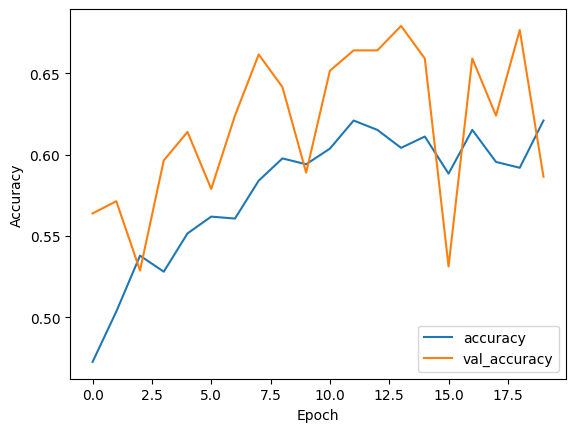

In [ ]:
#plotting
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
preds = cnn_model.predict(test_generator)
y_pred = np.argmax(preds, axis=1)

7/7 [==============================] - 1s 106ms/step


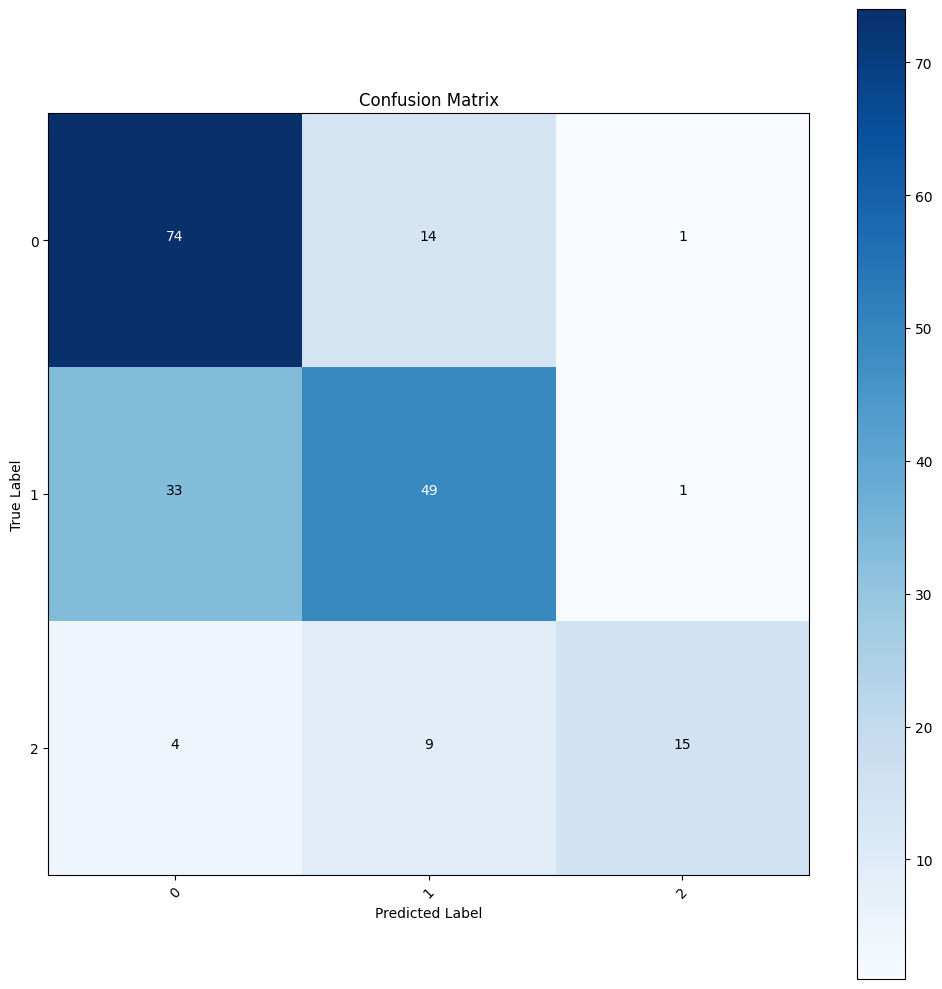

In [ ]:
g_dict = test_generator.class_indices
classes = list(g_dict.keys())
from sklearn.metrics import confusion_matrix
import itertools

# Confusion matrix
cm = confusion_matrix(test_generator.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
#VGG16 model

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)
test_datagen = ImageDataGenerator( rescale = 1.0/255. )
train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 20, class_mode = 'categorical', target_size = (224, 224))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory( valid_dir,  batch_size = 20, class_mode = 'categorical', target_size = (224, 224))

Found 4164 images belonging to 3 classes.
Found 399 images belonging to 3 classes.


In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape = (224, 224, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')


58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer with 3 nodes for classification output
x = layers.Dense(3, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss = 'categorical_crossentropy',metrics = ['acc'])


In [ ]:


# Set the number of training and validation steps
train_steps_per_epoch = len(train_generator)
valid_steps_per_epoch = len(validation_generator)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=valid_steps_per_epoch
)



Epoch 1/20
209/209 [==============================] - 97s 423ms/step - loss: 0.9730 - acc: 0.5355 - val_loss: 0.7251 - val_acc: 0.6441
Epoch 2/20
209/209 [==============================] - 80s 385ms/step - loss: 0.8286 - acc: 0.5973 - val_loss: 0.7377 - val_acc: 0.6817
Epoch 3/20
209/209 [==============================] - 92s 435ms/step - loss: 0.7913 - acc: 0.6167 - val_loss: 0.7045 - val_acc: 0.6992
Epoch 4/20
209/209 [==============================] - 78s 373ms/step - loss: 0.7826 - acc: 0.6302 - val_loss: 0.6655 - val_acc: 0.6742
Epoch 5/20
209/209 [==============================] - 65s 312ms/step - loss: 0.7760 - acc: 0.6294 - val_loss: 0.6737 - val_acc: 0.6867
Epoch 6/20
209/209 [==============================] - 66s 318ms/step - loss: 0.7627 - acc: 0.6297 - val_loss: 0.6678 - val_acc: 0.6792
Epoch 7/20
209/209 [==============================] - 62s 299ms/step - loss: 0.7560 - acc: 0.6422 - val_loss: 0.6881 - val_acc: 0.6992
Epoch 8/20
209/209 [==============================] - 6

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy*100:.2f}%')

7/7 [==============================] - 1s 121ms/step - loss: 0.7112 - acc: 0.6750
Test Accuracy: 67.50%


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


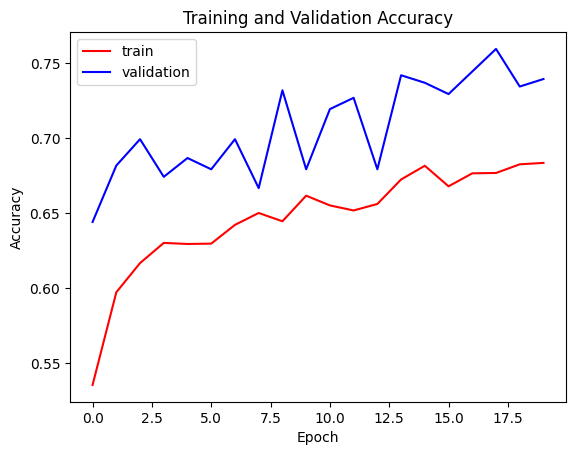

In [ ]:
import matplotlib.pyplot as plt

# Print the keys in the history dictionary
print(history.history.keys())

# Plot the training and validation accuracy
plt.plot(history.history['acc'], color='red', label='train')
plt.plot(history.history['val_acc'], color='blue', label='validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()

In [ ]:
preds = model.predict(test_generator)
y_pred = np.argmax(preds, axis=1)

7/7 [==============================] - 1s 108ms/step


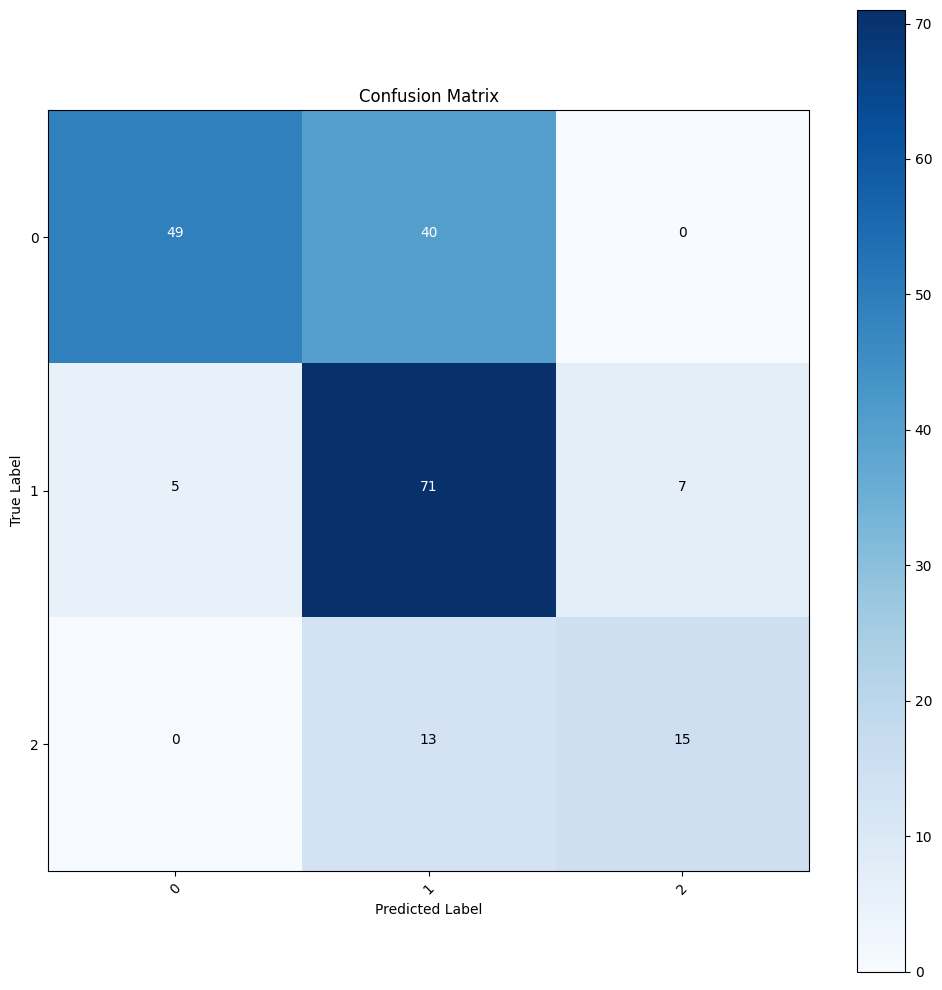

In [ ]:
g_dict = test_generator.class_indices
classes = list(g_dict.keys())
from sklearn.metrics import confusion_matrix
import itertools

# Confusion matrix
cm = confusion_matrix(test_generator.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
#InceptionV3 Model

In [ ]:

train_datagen = ImageDataGenerator(rescale = 1./255., rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2,shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

test_datagen = ImageDataGenerator( rescale = 1.0/255. )

In [ ]:
train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 20, class_mode = 'categorical', target_size = (150, 150))
validation_generator = test_datagen.flow_from_directory(valid_dir, batch_size = 20, class_mode = 'categorical', target_size = (150, 150))
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='categorical')

Found 4164 images belonging to 3 classes.
Found 399 images belonging to 3 classes.
Found 200 images belonging to 3 classes.


In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
base_model = InceptionV3(input_shape = (150, 150, 3), include_top = False, weights = 'imagenet')

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:

from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)

x = layers.Dense(3, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = RMSprop(learning_rate=0.0001), loss = 'categorical_crossentropy', metrics = ['acc'])

In [ ]:


# Set the number of training and validation steps
train_steps_per_epoch = len(train_generator)
valid_steps_per_epoch = len(validation_generator)

# Training the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=valid_steps_per_epoch
)

Epoch 1/20
209/209 [==============================] - 42s 170ms/step - loss: 1.1688 - acc: 0.6182 - val_loss: 0.9897 - val_acc: 0.6291
Epoch 2/20
209/209 [==============================] - 34s 162ms/step - loss: 0.7932 - acc: 0.6828 - val_loss: 0.6879 - val_acc: 0.7118
Epoch 3/20
209/209 [==============================] - 31s 150ms/step - loss: 0.7394 - acc: 0.6856 - val_loss: 0.6822 - val_acc: 0.7143
Epoch 4/20
209/209 [==============================] - 30s 146ms/step - loss: 0.6987 - acc: 0.7005 - val_loss: 0.6266 - val_acc: 0.7419
Epoch 5/20
209/209 [==============================] - 30s 143ms/step - loss: 0.6628 - acc: 0.7176 - val_loss: 0.9380 - val_acc: 0.7168
Epoch 6/20
209/209 [==============================] - 31s 148ms/step - loss: 0.6527 - acc: 0.7325 - val_loss: 0.7375 - val_acc: 0.7318
Epoch 7/20
209/209 [==============================] - 30s 143ms/step - loss: 0.6516 - acc: 0.7358 - val_loss: 0.8063 - val_acc: 0.6992
Epoch 8/20
209/209 [==============================] - 3

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy*100:.2f}%')

10/10 [==============================] - 0s 37ms/step - loss: 0.6503 - acc: 0.7350
Test Accuracy: 73.50%


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


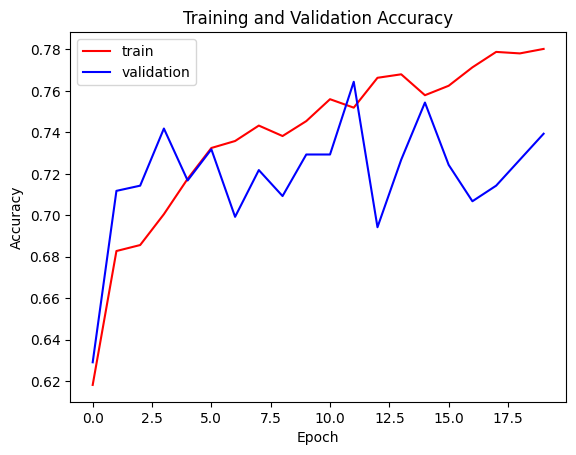

In [ ]:
import matplotlib.pyplot as plt

# Print the keys in the history dictionary
print(history.history.keys())

# Plot the training and validation accuracy
plt.plot(history.history['acc'], color='red', label='train')
plt.plot(history.history['val_acc'], color='blue', label='validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()


In [ ]:
preds = model.predict(test_generator)
y_pred = np.argmax(preds, axis=1)

10/10 [==============================] - 1s 51ms/step


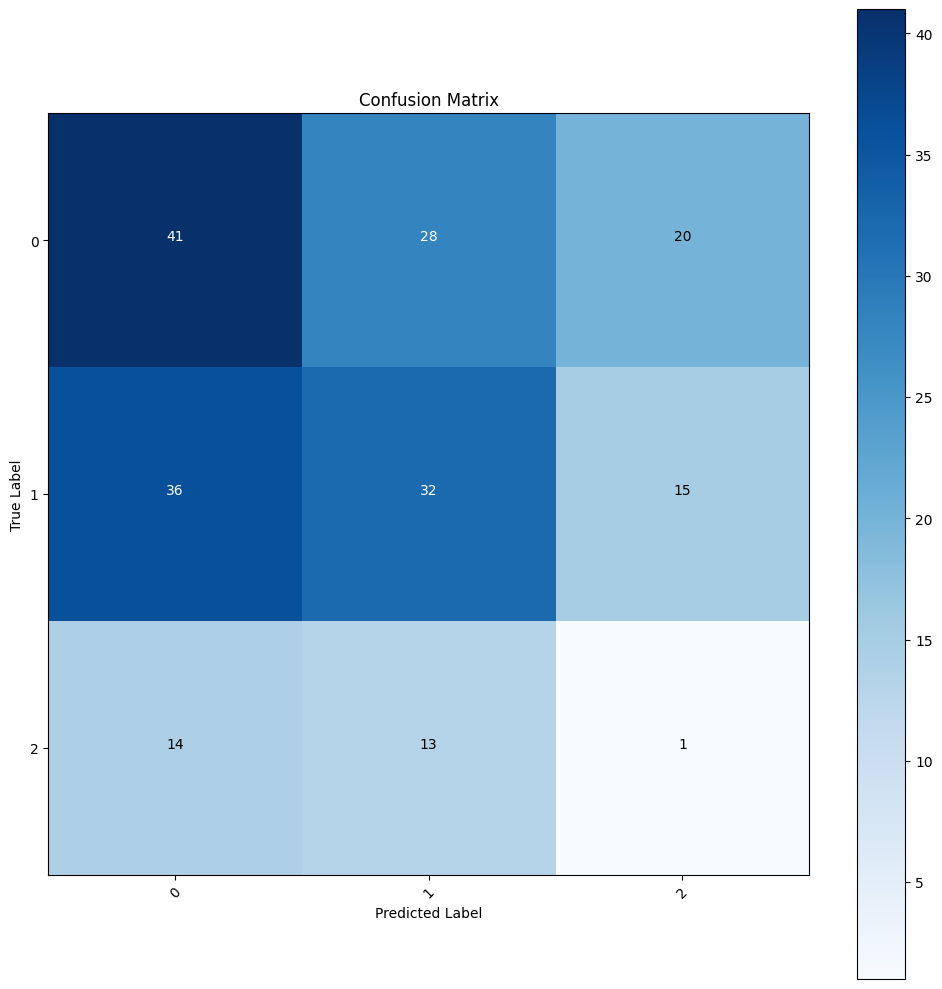

In [ ]:
g_dict = test_generator.class_indices
classes = list(g_dict.keys())
from sklearn.metrics import confusion_matrix
import itertools

# Confusion matrix
cm = confusion_matrix(test_generator.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
import cv2

In [ ]:
test_img=cv2.imread('/content/drive/MyDrive/Skin Burns.v3i.tensorflow/test/0/img1262_jpg.rf.77e6cc568b42e333d0408f482d9464e5.jpg')

In [ ]:
test_img.shape

(640, 640, 3)

In [ ]:

resized_test_img = cv2.resize(test_img, (150 150))

# Reshaping for prediction
resized_test_input = resized_test_img.reshape((1, 150, 150, 3))

# Making a prediction
prediction_result=model.predict(resized_test_input)
prediction_result

1/1 [==============================] - 0s 56ms/step


array([[1.0000000e+00, 5.5834045e-07, 2.5091007e-01]], dtype=float32)

In [ ]:
predicted_class = np.argmax(prediction_result)
predicted_class

0